In [ ]:
# pip install pandas torch transformers scikit-learn matplotlib -q
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [ ]:

# Carga de datos
file_path = '../../../Downloads/IBD_estructured_text.csv'

try:
    df = pd.read_csv(file_path)
    print("Archivo cargado exitosamente.")
    print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")
except FileNotFoundError:
    print(f" Error: No se encontró el archivo en la ruta: '{file_path}'")
    print("Por favor, verifica la ubicación de tu archivo.")

display(df.head())

✅ Archivo cargado exitosamente.
El dataset tiene 183744 filas y 8 columnas.


,id,subreddit,author,title,selftext,created_utc,comments,cuerpo
0,dflwn,CrohnsDisease,zakool21,Don't be afraid of diagnostic procedures....,"I'm not likely to frontpage this subreddit, bu...",2010-09-18 11:59:11,"['I have to agree, the worse part of a Colonos...",TÍTULO:\nDon't be afraid of diagnostic procedu...
1,dfyy1,CrohnsDisease,sphinctersayzwha,Mayo Clinic article on Crohn's Disease.,Mayo Clinic article on Crohn's Disease.,2010-09-19 15:11:21,[],TÍTULO:\nMayo Clinic article on Crohn's Diseas...
2,dfz1m,CrohnsDisease,WeDeserveDessert,Has anyone else here taken Remicade? What did...,Has anyone else here taken Remicade? What did...,2010-09-19 15:19:54,"[""Remicade (and a bypass) changed my life. Wh...",TÍTULO:\nHas anyone else here taken Remicade? ...
3,dh6zd,CrohnsDisease,RosenTurd,"I was Diagnosed With Crohns Disease at age 9 ,...",Like the title Says AMA,2010-09-22 04:50:57,"[""My son was diagnosed at ten. It's hell for h...",TÍTULO:\nI was Diagnosed With Crohns Disease a...
4,dhgot,CrohnsDisease,unknownpleasures,Has anyone here had to have bowel surgery more...,I had a small bowel resection and appendectomy...,2010-09-22 18:31:36,"[""I have a story:\n\nI had a small bowel resec...",TÍTULO:\nHas anyone here had to have bowel sur...


In [ ]:
# procesamiento y creación de etiqueta
df['cuerpo'] = "TÍTULO: " + df['title'].fillna('') + "\\n\\nCONTENIDO: " + df['selftext'].fillna('')


keywords = ['surgery', 'resection', 'ostomy', 'remicade', 'humira', 'biologic', 'fistula']
df['label'] = df['cuerpo'].str.contains('|'.join(keywords), case=False, na=False).astype(int)

print("Distribución de la columna 'label' creada:")
print(df['label'].value_counts())


Distribución de la columna 'label' creada:
label
0    143462
1     40282
Name: count, dtype: int64


In [ ]:
# configuración y carga del modelo BERT
MODELO_NOMBRE = "dmis-lab/biobert-base-cased-v1.2"

SAMPLE_SIZE = 2000 

if SAMPLE_SIZE:
    print(f"Usando una muestra de {SAMPLE_SIZE} registros para agilizar el proceso.")
    df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42)
else:
    print("Usando el dataset completo.")
    df_sample = df

print(f"Cargando el tokenizador y el modelo '{MODELO_NOMBRE}'... (Esto puede tardar un poco)")
tokenizer = AutoTokenizer.from_pretrained(MODELO_NOMBRE)
model = AutoModel.from_pretrained(MODELO_NOMBRE)
print("✅ Tokenizador y modelo cargados.")


Usando una muestra de 2000 registros para agilizar el proceso.
Cargando el tokenizador y el modelo 'dmis-lab/biobert-base-cased-v1.2'... (Esto puede tardar un poco)
✅ Tokenizador y modelo cargados.


In [ ]:
# transformación de texto a vectores embedings por lotes
textos = df_sample['cuerpo'].tolist()
etiquetas = df_sample['label'].tolist()

BATCH_SIZE = 32
todos_los_vectores = []

print(f"Procesando {len(textos)} textos en lotes de {BATCH_SIZE}...")


for i in range(0, len(textos), BATCH_SIZE):

    lote_textos = textos[i:i + BATCH_SIZE]
    

    inputs = tokenizer(lote_textos, padding=True, truncation=True, return_tensors="pt", max_length=512)
    

    with torch.no_grad():
        outputs = model(**inputs)
    

    vectores_lote = outputs.last_hidden_state[:, 0, :].numpy()
    todos_los_vectores.append(vectores_lote)
    
    print(f"  -> Lote {i // BATCH_SIZE + 1} procesado.")

vectores_bert = np.vstack(todos_los_vectores)

print("\n✅ ¡Textos transformados en vectores!")
print(f"Dimensiones de la matriz de características: {vectores_bert.shape}")

Procesando 2000 textos en lotes de 32...
  -> Lote 1 procesado.
  -> Lote 2 procesado.
  -> Lote 3 procesado.
  -> Lote 4 procesado.
  -> Lote 5 procesado.
  -> Lote 6 procesado.
  -> Lote 7 procesado.
  -> Lote 8 procesado.
  -> Lote 9 procesado.
  -> Lote 10 procesado.
  -> Lote 11 procesado.
  -> Lote 12 procesado.
  -> Lote 13 procesado.
  -> Lote 14 procesado.
  -> Lote 15 procesado.
  -> Lote 16 procesado.
  -> Lote 17 procesado.
  -> Lote 18 procesado.
  -> Lote 19 procesado.
  -> Lote 20 procesado.
  -> Lote 21 procesado.
  -> Lote 22 procesado.
  -> Lote 23 procesado.
  -> Lote 24 procesado.
  -> Lote 25 procesado.
  -> Lote 26 procesado.
  -> Lote 27 procesado.
  -> Lote 28 procesado.
  -> Lote 29 procesado.
  -> Lote 30 procesado.
  -> Lote 31 procesado.
  -> Lote 32 procesado.
  -> Lote 33 procesado.
  -> Lote 34 procesado.
  -> Lote 35 procesado.
  -> Lote 36 procesado.
  -> Lote 37 procesado.
  -> Lote 38 procesado.
  -> Lote 39 procesado.
  -> Lote 40 procesado.
  -> Lot

In [ ]:
# Entrenamiento y evaluacion
print("Dividiendo los datos y entrenando el modelo de clasificación...")


X_train, X_test, y_train, y_test = train_test_split(
    vectores_bert,
    etiquetas,
    test_size=0.2,
    random_state=42,
    stratify=etiquetas
)


classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)


predictions = classifier.predict(X_test)

print("Modelo entrenado y predicciones realizadas.")

Dividiendo los datos y entrenando el modelo de clasificación...
✅ Modelo entrenado y predicciones realizadas.



--- Reporte de Clasificación Final ---
               precision    recall  f1-score   support

No Riesgo (0)       0.86      0.94      0.90       315
   Riesgo (1)       0.64      0.42      0.51        85

     accuracy                           0.83       400
    macro avg       0.75      0.68      0.70       400
 weighted avg       0.81      0.83      0.81       400


--- Matriz de Confusión ---


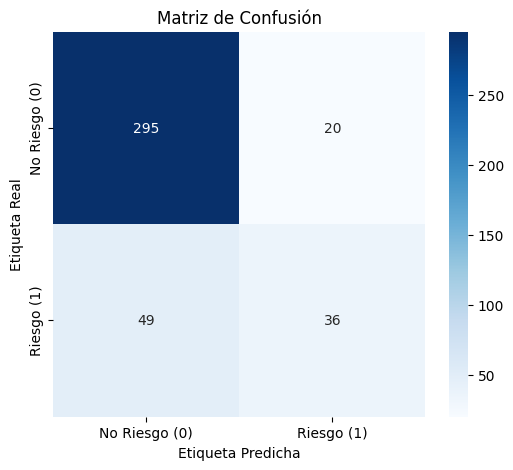

In [ ]:
# Resultados
print("\n--- Reporte de Clasificación Final ---")
print(classification_report(y_test, predictions, target_names=['No Riesgo (0)', 'Riesgo (1)']))

print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Riesgo (0)', 'Riesgo (1)'],
            yticklabels=['No Riesgo (0)', 'Riesgo (1)'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel

def obtener_vectores_bert(modelo_nombre, textos, batch_size=16):
    """
    Función que toma el nombre de un modelo de Hugging Face y una lista de textos,
    y devuelve una matriz de vectores (embeddings) generados por el modelo.
    """
    # 1. Cargar el tokenizador y el modelo específico
    print(f"\nCargando modelo: {modelo_nombre}...")
    tokenizer = AutoTokenizer.from_pretrained(modelo_nombre)
    model = AutoModel.from_pretrained(modelo_nombre)
    print("✅ Modelo cargado.")

    todos_los_vectores = []
    print(f"Procesando {len(textos)} textos en lotes de {batch_size}...")
    
    for i in range(0, len(textos), batch_size):
        lote_textos = textos[i:i + batch_size]

        inputs = tokenizer(lote_textos, padding=True, truncation=True, return_tensors="pt", max_length=512)
        

        with torch.no_grad():
            outputs = model(**inputs)
        

        vectores_lote = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        todos_los_vectores.append(vectores_lote)


    vectores_finales = np.vstack(todos_los_vectores)
    print(f"✅ Vectorización completada para {modelo_nombre}. Forma de la matriz: {vectores_finales.shape}")
    
    return vectores_finales

In [ ]:
# Compáracion de  bert y biobert
MODELO_BIOBERT = "dmis-lab/biobert-base-cased-v1.2"
MODELO_BERT_GENERAL = "bert-base-uncased"


textos_muestra = df_sample['cuerpo'].tolist()
etiquetas_muestra = df_sample['label'].tolist()

# --- Generar vectores con BioBERT ---
vectores_biobert = obtener_vectores_bert(MODELO_BIOBERT, textos_muestra)

# --- Generar vectores con BERT General ---
vectores_bert_general = obtener_vectores_bert(MODELO_BERT_GENERAL, textos_muestra)


Cargando modelo: dmis-lab/biobert-base-cased-v1.2...
✅ Modelo cargado.
Procesando 2000 textos en lotes de 16...
✅ Vectorización completada para dmis-lab/biobert-base-cased-v1.2. Forma de la matriz: (2000, 768)

Cargando modelo: bert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✅ Modelo cargado.
Procesando 2000 textos en lotes de 16...
✅ Vectorización completada para bert-base-uncased. Forma de la matriz: (2000, 768)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# --- CLASIFICADOR 1: ENTRENADO CON VECTORES DE BIOBERT ---
print("\n" + "="*50)
print("---BioBERT ---")
print("="*50)

X_train_bio, X_test_bio, y_train, y_test = train_test_split(
    vectores_biobert, etiquetas_muestra, test_size=0.2, random_state=42, stratify=etiquetas_muestra
)

classifier_bio = LogisticRegression(max_iter=1000)
classifier_bio.fit(X_train_bio, y_train)
predictions_bio = classifier_bio.predict(X_test_bio)

print(classification_report(y_test, predictions_bio, target_names=['No Riesgo (0)', 'Riesgo (1)']))


# --- CLASIFICADOR 2: ENTRENADO CON VECTORES DE BERT GENERAL ---
print("\n" + "="*50)
print("---  BERT General ---")
print("="*50)

X_train_gen, X_test_gen, y_train, y_test = train_test_split(
    vectores_bert_general, etiquetas_muestra, test_size=0.2, random_state=42, stratify=etiquetas_muestra
)

classifier_gen = LogisticRegression(max_iter=1000)
classifier_gen.fit(X_train_gen, y_train)
predictions_gen = classifier_gen.predict(X_test_gen)

print(classification_report(y_test, predictions_gen, target_names=['No Riesgo (0)', 'Riesgo (1)']))


---BioBERT ---
               precision    recall  f1-score   support

No Riesgo (0)       0.86      0.94      0.90       315
   Riesgo (1)       0.67      0.44      0.53        85

     accuracy                           0.83       400
    macro avg       0.77      0.69      0.71       400
 weighted avg       0.82      0.83      0.82       400


---  BERT General ---
               precision    recall  f1-score   support

No Riesgo (0)       0.86      0.93      0.89       315
   Riesgo (1)       0.62      0.42      0.50        85

     accuracy                           0.82       400
    macro avg       0.74      0.68      0.70       400
 weighted avg       0.81      0.82      0.81       400

